In [24]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.metrics import make_scorer, f1_score, accuracy_score, recall_score, precision_score, classification_report, precision_recall_fscore_support

import itertools


In [4]:
# file used to write preserve the results of the classfier
# confusion matrix and precision recall fscore matrix

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.tight_layout()
    return plt

In [5]:
##saving the classification report
def pandas_classification_report(y_true, y_pred):
    metrics_summary = precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred)
    cm = confusion_matrix(y_true, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    
    avg = list(precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred,
            average='macro'))
    avg.append(accuracy_score(y_true, y_pred, normalize=True))
    metrics_sum_index = ['precision', 'recall', 'f1-score', 'support','accuracy']
    list_all=list(metrics_summary)
    list_all.append(cm.diagonal())
    class_report_df = pd.DataFrame(
        list_all,
        index=metrics_sum_index)

    support = class_report_df.loc['support']
    total = support.sum() 
    avg[-2] = total

    class_report_df['avg / total'] = avg

    return class_report_df.T

In [6]:
from commen_preprocess import *

.....start_cleaning.........
hashtag britain exit hashtag rape refugee


In [7]:
from sklearn.metrics import accuracy_score
import joblib
from sklearn.model_selection import StratifiedKFold as skf


###all classifier 
from catboost import CatBoostClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn import neighbors
from sklearn import ensemble
from sklearn import neural_network
from sklearn import linear_model
import lightgbm as lgbm
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from nltk.classify.scikitlearn import SklearnClassifier


In [8]:
eng_train_dataset = pd.read_csv('../Data/english_dataset/english_dataset.tsv', sep='\t')


In [9]:
eng_train_dataset.head()

,text_id,text,task_1,task_2,task_3
0,hasoc_en_1,#DhoniKeepsTheGlove | WATCH: Sports Minister K...,NOT,NONE,NONE
1,hasoc_en_2,@politico No. We should remember very clearly ...,HOF,HATE,TIN
2,hasoc_en_3,@cricketworldcup Guess who would be the winner...,NOT,NONE,NONE
3,hasoc_en_4,Corbyn is too politically intellectual for #Bo...,NOT,NONE,NONE
4,hasoc_en_5,All the best to #TeamIndia for another swimmin...,NOT,NONE,NONE


In [10]:
l=eng_train_dataset['task_1'].value_counts()
print("the total dataset size:",len(eng_train_dataset),'\n',l)

the total dataset size: 5852 
 NOT    3591
HOF    2261
Name: task_1, dtype: int64


In [11]:
import numpy as np
from tqdm import tqdm
import pickle
####loading laser embeddings for english dataset
def load_laser_embeddings():
        dim = 1024
        engX_commen = np.fromfile("../Data/english_dataset/embeddings_eng_task1_commen.raw", dtype=np.float32, count=-1)                                                                          
        engX_lib = np.fromfile("../Data/english_dataset/embeddings_eng_task1_lib.raw", dtype=np.float32, count=-1)                                                                          
        engX_commen.resize(engX_commen.shape[0] // dim, dim)                                                                          
        engX_lib.resize(engX_lib.shape[0] // dim, dim)                                                                          
        return engX_commen,engX_lib
    
def load_bert_embeddings():
        file = open('../Data/english_dataset/no_preprocess_bert_embed_task1.pkl', 'rb')
        embeds = pickle.load(file)
        return np.array(embeds)
        
def merge_feature(*args):
    feat_all=[]
    print(args[0].shape)
    for  i in tqdm(range(args[0].shape[0])):
        feat=[]
        for arg in args:
            feat+=list(arg[i])
        feat_all.append(feat)
    return feat_all
        

In [12]:
convert_label={
    'HOF':1,
    'NOT':0
}


convert_reverse_label={
    1:'HOF',
    0:'NOT'
}


In [13]:
labels=eng_train_dataset['task_1'].values
engX_commen,engX_lib=load_laser_embeddings()
bert_embeds =load_bert_embeddings()

In [14]:
feat_all=merge_feature(engX_commen,engX_lib,bert_embeds)
#feat_all=merge_feature(engX_lib)


# feat_all=[]
# for  i in range(len(labels)):
#     feat=list(engX_commen[i])+list(engX_lib[i])
#     feat_all.append(feat)

 16%|█▋        | 962/5852 [00:00<00:00, 4949.05it/s]

(5852, 1024)


100%|██████████| 5852/5852 [00:01<00:00, 4545.82it/s]


In [15]:
len(feat_all[0])

2816

In [16]:
from sklearn.utils.multiclass import type_of_target

Classifier_Train_X=np.array(feat_all)
labels_int=[]
for i in range(len(labels)):
    labels_int.append(convert_label[labels[i]])

Classifier_Train_Y=np.array(labels_int,dtype='float64')
    

In [17]:
print(type_of_target(Classifier_Train_Y))
Classifier_Train_Y

binary


array([0., 1., 0., ..., 1., 1., 1.])

In [18]:
x

NameError: name 'x' is not defined

In [19]:
from sklearn.metrics import f1_score

def train_model_no_ext(Classifier_Train_X,Classifier_Train_Y,model_type,save_model=False):
    kf = skf(n_splits=10,shuffle=True)
    y_total_preds=[] 
    y_total=[]
    count=0
    img_name = 'cm.png'
    report_name = 'report.csv'
    
    scale=list(Classifier_Train_Y).count(0)/list(Classifier_Train_Y).count(1)
    print(scale)
    
    if(save_model==True):
        Classifier=get_model(scale,m_type=model_type)
        Classifier.fit(Classifier_Train_X,Classifier_Train_Y)
        filename = model_type+'_eng_task_1.joblib.pkl'
        joblib.dump(Classifier, filename, compress=9)
#         filename1 = model_name+'select_features_eng_task1.joblib.pkl'
#         joblib.dump(model_featureSelection, filename1, compress=9)
    else:
        for train_index, test_index in kf.split(Classifier_Train_X,Classifier_Train_Y):
            X_train, X_test = Classifier_Train_X[train_index], Classifier_Train_X[test_index]
            y_train, y_test = Classifier_Train_Y[train_index], Classifier_Train_Y[test_index]

            classifier=get_model(scale,m_type=model_type)
            print(type(y_train))
            classifier.fit(X_train,y_train)
            y_preds = classifier.predict(X_test)
            for ele in y_test:
                y_total.append(ele)
            for ele in y_preds:
                y_total_preds.append(ele)
            y_pred_train = classifier.predict(X_train)
            print(y_pred_train)
            print(y_train)
            count=count+1       
            print('accuracy_train:',accuracy_score(y_train, y_pred_train),'accuracy_test:',accuracy_score(y_test, y_preds))
            print('TRAINING:')
            print(classification_report( y_train, y_pred_train ))
            print("TESTING:")
            print(classification_report( y_test, y_preds ))
        f1score=f1_score(y_total, y_total_preds, average='macro')
        report = classification_report( y_total, y_total_preds )
        cm=confusion_matrix(y_total, y_total_preds)
        plt=plot_confusion_matrix(cm,normalize= True,target_names = ['NOT','HOF'],title = "Confusion Matrix")
        plt.savefig('eng_task1'+model_type+'_'+img_name)
        print(classifier)
        print(report)
        print(accuracy_score(y_total, y_total_preds))
        df_result=pandas_classification_report(y_total,y_total_preds)
        df_result.to_csv('eng_task1'+model_type+'_'+report_name,  sep=',')
        return f1score

In [20]:
def get_model(scale,m_type=None):
    if not m_type:
        print("ERROR: Please specify a model type!")
        return None
    if m_type == 'decision_tree_classifier':
        logreg = tree.DecisionTreeClassifier(max_features=1000,max_depth=3,class_weight='balanced')
    elif m_type == 'gaussian':
        logreg = GaussianNB()
    elif m_type == 'logistic_regression':
        logreg = LogisticRegression(n_jobs=10, random_state=42,class_weight='balanced',solver='liblinear')
    elif m_type == 'MLPClassifier':
#         logreg = neural_network.MLPClassifier((500))
        logreg = neural_network.MLPClassifier((100),random_state=42,early_stopping=True,class_weight='balanced')
    elif m_type == 'KNeighborsClassifier':
#         logreg = neighbors.KNeighborsClassifier(n_neighbors = 10)
        logreg = neighbors.KNeighborsClassifier()
    elif m_type == 'ExtraTreeClassifier':
        logreg = tree.ExtraTreeClassifier()
    elif m_type == 'ExtraTreeClassifier_2':
        logreg = ensemble.ExtraTreesClassifier()
    elif m_type == 'RandomForestClassifier':
        logreg = ensemble.RandomForestClassifier(n_estimators=100, class_weight='balanced', n_jobs=12, max_depth=7)
    elif m_type == 'SVC':
        #logreg = LinearSVC(dual=False,max_iter=200)
        logreg = SVC(kernel='linear',random_state=1526)
    elif m_type == 'Catboost':
        logreg = CatBoostClassifier(iterations=100,learning_rate=0.2,l2_leaf_reg=500,depth=10,use_best_model=False, random_state=42,scale_pos_weight=SCALE_POS_WEIGHT)
#         logreg = CatBoostClassifier(scale_pos_weight=0.8, random_seed=42,);
    elif m_type == 'XGB_classifier':
#         logreg=XGBClassifier(silent=False,eta=0.1,objective='binary:logistic',max_depth=5,min_child_weight=0,gamma=0.2,subsample=0.8, colsample_bytree = 0.8,scale_pos_weight=1,n_estimators=500,reg_lambda=3,nthread=12)
        logreg=XGBClassifier(silent=False,objective='binary:logistic',scale_pos_weight=SCALE_POS_WEIGHT,reg_lambda=3,nthread=12, random_state=42)
    elif m_type == 'light_gbm':
        logreg = LGBMClassifier(objective='binary',max_depth=3,learning_rate=0.2,num_leaves=20,scale_pos_weight=scale,boosting_type='gbdt',
                                metric='binary_logloss',random_state=5,reg_lambda=20,silent=False)
    else:
        print("give correct model")
    print(logreg)
    return logreg

In [21]:
models_name=['decision_tree_classifier','gaussian','logistic_regression','MLPClassifier','RandomForestClassifier',
             'SVC','light_gbm']
for model in models_name:
    train_model_no_ext(Classifier_Train_X,Classifier_Train_Y,model)


1.588235294117647
DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=3,
            max_features=1000, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
<class 'numpy.ndarray'>
[0. 1. 1. ... 1. 0. 1.]
[0. 1. 0. ... 0. 1. 1.]
accuracy_train: 0.576068376068376 accuracy_test: 0.5706984667802385
TRAINING:
              precision    recall  f1-score   support

         0.0       0.78      0.43      0.56      3231
         1.0       0.47      0.80      0.59      2034

   micro avg       0.58      0.58      0.58      5265
   macro avg       0.62      0.62      0.58      5265
weighted avg       0.66      0.58      0.57      5265

TESTING:
              precision    recall  f1-score   support

         0.0       0.76      0.43      0.55       360
         1.0       0.47      0.79 

KeyboardInterrupt: 

1.588235294117647
DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=3,
            max_features=1000, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
<class 'numpy.ndarray'>
[0. 0. 0. ... 1. 0. 1.]
[0. 1. 0. ... 1. 1. 1.]
accuracy_train: 0.6442545109211776 accuracy_test: 0.5979557069846678
TRAINING:
              precision    recall  f1-score   support

         0.0       0.74      0.65      0.69      3231
         1.0       0.53      0.63      0.58      2034

   micro avg       0.64      0.64      0.64      5265
   macro avg       0.64      0.64      0.64      5265
weighted avg       0.66      0.64      0.65      5265

TESTING:
              precision    recall  f1-score   support

         0.0       0.71      0.59      0.64       360
         1.0       0.48      0.62

[0. 0. 1. ... 0. 1. 1.]
[0. 0. 0. ... 1. 1. 1.]
accuracy_train: 0.5468008353901652 accuracy_test: 0.5264957264957265
TRAINING:
              precision    recall  f1-score   support

         0.0       0.77      0.37      0.50      3232
         1.0       0.45      0.82      0.58      2035

   micro avg       0.55      0.55      0.55      5267
   macro avg       0.61      0.60      0.54      5267
weighted avg       0.65      0.55      0.53      5267

TESTING:
              precision    recall  f1-score   support

         0.0       0.76      0.34      0.47       359
         1.0       0.44      0.83      0.57       226

   micro avg       0.53      0.53      0.53       585
   macro avg       0.60      0.58      0.52       585
weighted avg       0.63      0.53      0.51       585

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=3,
            max_features=1000, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min

0.5877180059792395

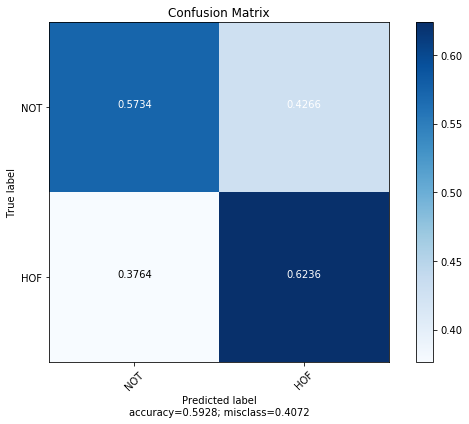

In [52]:
f1score=train_model_no_ext(Classifier_Train_X,Classifier_Train_Y,models_name[0])


In [25]:
train_model_no_ext(Classifier_Train_X,Classifier_Train_Y,models_name[-1],save_model=True)

1.588235294117647
LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.2, max_depth=3,
        metric='binary_logloss', min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective='binary', random_state=5,
        reg_alpha=0.0, reg_lambda=20, scale_pos_weight=1.588235294117647,
        silent=False, subsample=1.0, subsample_for_bin=200000,
        subsample_freq=0)
